# QUESTION 4 AND 5

### (1) INCLUDING THE LIBRARIES NEEDS FOR THE CODE

In [10]:
import csv,re,numpy            
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import nltk, sklearn
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
#from nltk.util import ngrams

### (2) LOADING DATA AND SPLITTING DATA INTO TRAIN AND TEST
1. TOOK THE TAB DELIMITIED TEXT FILE AS INPUT
2. READ THE DOCUMENT LINE BY LINE
3. PARSED LINE BY LINE 
4. SPLIT THE DOCUMENT INTO TWO SETS(TRAINING AND TEST SET)
5. THE PERCENTAGE IS PROVIDED AS INPUT FOR SPLITTING (GENERALLY 80% CONSIDERED TRAINING DATA WHILE SPLITTING)
6. THE PREPROCESS AND THE FEATURE CONVERSION TAKES PLACE DURING SPLITTING (BY CALLING THEIR RESPECTIVE USER DEFINED FUNCTIONS)

In [11]:
# load data from a file and append it to the rawData
def loadData(path, Text=None):
    with open(path,encoding = "utf-8") as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "DOC_ID":  # skip the header
                continue
            (Id, Rating, v_Purchase, p_Category, p_ID, Text, Label) = parseReview(line)
            rawData.append((Id, Rating, v_Purchase, p_Category, p_ID, Text, Label))
            
def splitData(percentage):
    # A method to split the data between trainData and testData 
    dataSamples = len(rawData)
    halfOfData = int(len(rawData)/2)

    trainingSamples = int((percentage*dataSamples)/2)
    for (_, Rating, v_Purchase, p_Category, p_ID, Text, Label) in rawData[:trainingSamples] + rawData[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(Rating, v_Purchase, p_Category, p_ID, preProcess(Text)),Label))
        
    for (_, Rating, v_Purchase, p_Category, p_ID, Text, Label) in rawData[trainingSamples:halfOfData] + rawData[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(Rating, v_Purchase, p_Category, p_ID, preProcess(Text)),Label))

### (3) PARSING DATA:
1. SPLIT INPUT INTO FOLLOWING PARTS:
    * DOC_ID
    * RATING
    * VERIFIED_PURCHASE
    * PRODUCT_CATEGORY
    * PRODUCT_ID
    * REVIEW_TEXT 
    * LABEL

2. THE LABEL FROM INPUT IS ASSIGNED VALUE AS PER THE REQUIRED OUTPUT CLASSES  <b>(<i>fake, real</i>)</b>
3. THE FUNCTION RETURNS A TUPLE: <b>(<i>Id, Rating, Verified Purchase, Product Category, Text, Label</i>)</b>
4. EXTRA FEATURES HAVE BEEN EXTRACTED TO EXPLORE AND UNDERSTAND THE PERFORMANCE BASED ON THEIR INCLUSION AS FEATURES.

In [12]:
# Convert line from input file into an id/text/label tuple
def parseReview(reviewLine):
    (Id, Rating, v_Purchase, p_Category, p_ID, Text, Label) = (int(reviewLine[0]), 
                                                               reviewLine[2], reviewLine[3],
                                                               reviewLine[4], reviewLine[5], reviewLine[8],
                                                               fakeLabel if reviewLine[1]=='__label1__' else realLabel)
    #print(Id, Rating, v_Purchase, p_Category, p_ID, Text, Label)
    return (Id, Rating, v_Purchase, p_Category, p_ID, Text, Label)

### (4) PREPROCESSING: 
1. IDENTIFIED AND REMOVED THE HYPER LINKS, THE SPECIAL CHARACTERS, THE HTML TAGS (using regex)
3. IDENTIFIED THE CONTRACTIONS AND REMOVED THE APOSTROPHE (using regex)
5. REPLACED ALL THE SPECIAL CHARACTERS WITH WHITESPACES (using regex)
6. CREATED TOKENS OF INDIVIDUAL WORDS USING STANDARD FUNCTION <b>(<i>nltk.word_tokenize())</i>))</b>
6. REMOVED NUMERIC DATA (using regex)
7. REMOVED THE EMPTY ENTRIES, CREATED AS THE RESULT OF POINT 3, IN THE TOKEN LIST (using regex)
8. CONVERTED ALL TOKENS TO LOWERCASE (using regex)
8. LEMMATIZED TOKENS USING STANDARD FUNCTION <b>(<i>nltk.stem.WordNetLemmatizer.lemmatize()</i>))</b>
8. TRIED THE FOLLOWING STEMMING. BUT THE FEATURES REDUCED CONSIDERABLY. SO WITHDRAV MYSELF FROM USING IT. 
    *  <b>(<i>nltk.stem.PorterStemmer.stem()</i>)</b>
    *  <b>(<i>nltk.stem.LancasterStemmer.stem()</i>)</b>
    *  <b>(<i>nltk.stem.SnowballStemmer.stem()</i>)</b>
8. INCLUDED THE STOPWORDS FROM CORPUS TO CHECK AND REMOVE THEM FROM TOKENS DURING LEMMATATION PROCESS 
    *  <b>(<i>nltk.corpus.stopwords.words('english')</i>))</b>
8. BIGRAM WAS USED TO FURTHER ENHANCE THE FEATURE COUNT nltk.util import ngrams
9. THE FUNCTION RETURNS TOKEN LIST THUS COMPLETING THE TOKENIZATION PROCESS, AND THE PREPROCESSING.

In [13]:
spl_char = {}
hpr_link = {}
swords = {}
numbers = {}

# Input: a string of one review

    
    ###=======================================###
     ###### PREPROCESS STAGES USING REGEX ###### 
    ###=======================================### 

def preProcess(text):# Should return a list of tokens
    hprlink = re.findall("http\S+",text) #find all hyperlink
    splchar = re.findall("\W",text) #find all special characters
    
    # Save the hyperlinks and special characters in dictionary for future analysis
    for h in hprlink:
        try:
            i = hpr_link[h]
        except KeyError:
            i = len(hpr_link) + 1
            hpr_link[h] = i            
    
    for s in splchar:
        try:
            i = spl_char[s]
        except KeyError:
            i = len(spl_char) + 1
            spl_char[s] = i

    # removing hyper link, html tags, contraction, and other special characters inorder to tokenize
    text = re.sub(r"http\S+", "", text) 
    text = re.sub('<.*?>', '', text)
    #print(text)
    text = re.sub(r"(\w)(['’])(\w)", r"\1\3", text) #contraction 
    text = re.sub(r"\W", r" ", text)
    tokens =  word_tokenize(text) 
    #print(tokens)
    tokens = [t.lower() for t in tokens] # converting text to lower case
    
    
    ###=======================================###
            ###### LEMMATIZATION ###### 
    ###=======================================###   
    
    lemma = WordNetLemmatizer()
    
    no_sw_tokens=[]
    stop_words = set(stopwords.words('english'))
    
    for w in tokens:
        if w not in stop_words:
            no_sw_tokens.append(lemma.lemmatize(w))
        else:
            try:
                i = swords[w]
            except KeyError:
                i = len(swords) + 1
                swords[w] = i

    #print(no_sw_tokens)
    
    ###=======================================###
            ###### REMOVING NUMBERS ###### 
    ###=======================================###      
    clean_tokens = []
    for token in no_sw_tokens:
        if token.isnumeric() == False:
                 clean_tokens.append(token)
        else:
            try:
                i = numbers[token]
            except KeyError:
                i = len(numbers) + 1
                numbers[token] = i  
    #print(clean_tokens)
     
    ###=======================================###
            ###### STEMMING ###### 
    ###=======================================###

    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    snow = SnowballStemmer("english") 
    stemmed_tokens = []
     
    #stemming PorterStemmer, LancasterStemmer, SnowballStemmer
    def PstemTokens(clean_tokens):
        for word in clean_tokens:
            stemmed_tokens.append(porter.stem(word))
        return stemmed_tokens
            
    """            
    LancasterStemmer is simple, but heavy stemming due to iterations and over-stemming may occur. 
    Over-stemming causes the stems to be not linguistic, or they may have no meaning.    
    """
    
    def LstemTokens(clean_tokens):
        for word in clean_tokens:
            stemmed_tokens.append(lancaster.stem(word))
        return stemmed_tokens
    
    def SstemTokens(clean_tokens):
        for word in clean_tokens:
            stemmed_tokens.append(snow.stem(word))
        return stemmed_tokens
            
    #stemmed_tokens = PstemTokens(clean_tokens)
    #stemmed_tokens = LstemTokens(tokens) 
    stemmed_tokens = SstemTokens(tokens) 

    #print(clean_tokens)
    #print(final_tokens)
    #print(stemmed_tokens)
    
    final_tokens = [' '.join(l) for l in nltk.bigrams(stemmed_tokens)] + stemmed_tokens
    #final_tokens = [' '.join(l) for l in nltk.bigrams(clean_tokens)] + clean_tokens
    
    #return stemmed_tokens
    #return clean_tokens
    return final_tokens


#with open('tokenize.txt', 'w', encoding="utf-8") as f:
#    f.write(str(final_tokens))
#    f.write(str(swords))
#    f.write(str(numbers))
#    f.close

### (5) CONVERTING THE TOKENS TO FEATURES

1.  THE GLOBAL DICTIONARY IS FILLED WITH THE FEATURES THAT ARE ENCOUNTED DURING THE WHOLE FEATURE VECTOR CREATION PROCESS 
2.  BINARY FEATURE VALUES HAVE BEEN USED FOR EACH REVIEW 
3.  FOR THE ADDITIONAL FEATURES ADDED(Rating, v_Purchase, p_Category,p_ID) LOCAL DICTIONARY HAVE 
     * RATINGS 1 TO 5
     * THE VERIFIED PURCHASE AS 1 IF PRESENT AND 0 OTHERWISE
     * THE PRODUCT ID AS 1 IF PRESENT AND 0 OTHERWISE
     * THE PRODUCT CATEGORY AS 1 IF PRESENT AND 0 OTHERWISE
     
4.  I HAVE NOT INCLUDED THE PRODUCT TITLE 

In [14]:
featureDict = {} # A global dictionary of features

def toFeatureVector(Rating, v_Purchase, p_Category, p_ID, tokens):
    localDict = {}

    #Rating
    
    #print(Rating)
    featureDict["R"] = 1   
    localDict["R"] = Rating
    
    #Verified Purchase
    featureDict["VP"] = 1
         
    if v_Purchase == "N":
        localDict["VP"] = 0
    else:
        localDict["VP"] = 1

    #Product Category  
    if p_Category not in featureDict:
        featureDict[p_Category] = 1
    else:
        featureDict[p_Category] = +1
            
    if p_Category not in localDict:
        localDict[p_Category] = 1
    else:
        localDict[p_Category] = +1
        
    #Product ID
    if p_ID not in featureDict:
        featureDict[p_ID] = 1
    else:
        featureDict[p_ID] = +1
            
    if p_Category not in localDict:
        localDict[p_ID] = 1
    else:
        localDict[p_ID] = +1
    

    #Text        
    for token in tokens:
        if token not in featureDict:
            featureDict[token] = 1
        else:
            featureDict[token] = +1
            
        if token not in localDict:
            localDict[token] = 1
        else:
            localDict[token] = +1
    
    #for token in tokens:
    #    try:
    #        i = featureDict[token]
    #    except KeyError:
    #        i = len(featureDict) + 1
    #        featureDict[token] = i
    #    try:
    #        localDict[i] += (1.0/len(tokens))
    #    except KeyError:
    #        localDict[i] = (1.0/len(tokens))            
    #        
    #print(featureDict)
    #print(localDict) 
    
    return localDict

### (6) TRAINING AND VALIDATING OUR CLASSIFIER

In [15]:
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainData)

### (7) CROSS VALIDATING

1. THE 10 FOLD CROSS VALIDATION IS PERFORMED WHERE THE TRAINING DATA (80% OF THE WHOLE DATA) IS SPLIT IS 10 FOLDS AND EACH FOLD ACT AS TEST DATA AND THE REMAINING 10 FOLD ARE TRAINING DATA. 
2. THIS IS ACCOMPLISHED BY PUTTING THE FOLDS IN LOOP AND ROTATING THE FOLDS TO ACT AS TRAINING AND TEST DATA 
3. THUS IT FOLLOWS THE PATTERN: 
    * TRAIN DATA: [:i]  
    * TEST DATA [i:foldSize+i] 
    * TRAIN DATA [foldSize+i:] 
    COMBINED PROPERLY IN THE CODE WITH CONCATENATION 
4. THE MAIN CODE CALLS THE CROSS VALIDATE WITH 80% OF THE MAIN DATASET AND THE NUMBER OF FOLDS AS PARAMETERS
5. THE TEST DATA LABELS ARE GATHERED BEFORE PREDICTING ON THE TEST DATA
6. THE GATHERED LABELS AND PREDICTED LABELS ARE PASSED ON TO STANDARD FUNCTIONS TO IDENTIFY THE FOLLOWING:
    * PRECISON <b>(<i>sklearn.metrics.precision_recall_fscore_support()</i>)</b>
    * RECALL <b>(<i>sklearn.metrics.precision_recall_fscore_support()</i>)</b>
    * F-SCORE <b>(<i>sklearn.metrics.precision_recall_fscore_support()</i>)</b>
    * THE ABOVE VALUES RETURNED AS TUPLE BY THE FUNCTION
    * ACCURACY <b>(<i>sklearn.metrics.accuracy_score()</i>)</b>
7. THE AVERAGE OF EACH SCORE IS TAKEN USING MEAN 
8. FINAL RESULT IS RETURNED TO THE CALLING CODE

In [16]:
def crossValidate(dataset, folds):
    shuffle(dataset)
    foldSize = int(len(dataset)/folds)
    # DESCRIBE YOUR METHOD IN WORDS
    cv_results, precision, accuracy, recall,fbeta = ([] for i in range(5)) 
    for i in range(0,len(dataset),foldSize):     
        
        testData = dataset[i:foldSize+i]
        trainData = dataset[:i] + dataset[foldSize+i:] 


        #Fold 1 through 10 is picked in for each for loop   
              
        classifier = trainClassifier(trainData)
        #store the labels
        testTrue = [t[1] for t in testData]   #get the ground-truth labels from the data
        
        #classify the test data to get predicted labels
        testPred = predictLabels(testData,classifier)
        
        AS = accuracy_score(testTrue, testPred)
        (PC, RC, F1S,_) = precision_recall_fscore_support(testTrue, testPred, average='weighted') # evaluate
        
        precision.append(PC)
        recall.append(RC)
        fbeta.append(F1S)
        accuracy.append(AS)
        
        # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
        # P = tp/(tp+fp)
        # R = tp/(tp+fn)

    cv_results = [sum(precision)/folds, sum(recall)/folds, sum(fbeta)/folds, sum(accuracy)/folds]
    #print(cv_results)
    return cv_results

In [17]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

def predictLabel(reviewSample, classifier):
    return classifier.classify(toFeatureVector(preProcess(reviewSample)))

In [18]:
#### MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
trainData = []        # the pre-processed training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the pre-processed test data as a percentage of the total dataset (currently 20%, or 4200 samples)

# the output classes
fakeLabel = 'fake'
realLabel = 'real'

# references to the data files
reviewPath = 'amazon_reviews.txt'

# We parse the dataset and put it in a raw data list
print("Now %d Raw Data, %d Train Data, %d Test Data" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')

print('\n')
loadData(reviewPath) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d Train Data, %d Test Data" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')

splitData(0.8)

print('\n')
# We print the number of training samples and the number of features after the split
print("After split, %d Raw Data, %d Train Data, %d Test Data" % (len(rawData), len(trainData), len(testData)),'\n',
      "Training Samples: %d" % len(trainData), "Features: %d" % len(featureDict), sep='\n')

print('\n')

# QUESTION 3 - Make sure there is a function call here to the
# crossValidate function on the training set to get your results

print("K Fold cross-validation: ")
print('\n')
CV_Results= crossValidate(trainData, 10)
print(
      "Precision:", CV_Results[0],
      ", Recall:", CV_Results[1],
      ", F Score", CV_Results[2],
      ", Accuracy:", CV_Results[3])
#print(trainData[7]) 
#with open('featureDict.txt', 'w', encoding="utf-8") as f:
#    f.write(str(featureDict))
#    f.close


Now 0 Raw Data, 0 Train Data, 0 Test Data
Preparing the dataset...


Now 21000 rawData, 0 Train Data, 0 Test Data
Preparing training and test data...


After split, 21000 Raw Data, 16800 Train Data, 4200 Test Data


Training Samples: 16800
Features: 410817


K Fold cross-validation: 


Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Precision: 0.7930421783749483 , Recall: 0.792797619047619 , F Score 0.7927805676815118 , Accuracy: 0.792797619047619


### (8) Evaluate on test set

In [19]:
# Finally, check the accuracy of your classifier by training on all the tranin data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(testData[7])  # have a look at the first test data instance
    print('\n')
    finalScores = []
    classifier = trainClassifier(trainData)  # train the classifier
    testTrue = [t[1] for t in testData]   # get the ground-truth labels from the data
    testPred = predictLabels(testData, classifier)  # classify the test data to get predicted labels
    accuracy = accuracy_score(testTrue, testPred)
    (precision,recall,fbeta,_) = precision_recall_fscore_support(testTrue, testPred, average='weighted') # evaluate
    
    finalScores.append(precision)
    finalScores.append(recall)
    finalScores.append(fbeta)
    finalScores.append(accuracy)
    

    print('\n')
    print("Done training!")
    print('\n')
    print('\t',"Precision:", finalScores[0],'\n',
          '\t',"Recall:", finalScores[1],'\n',
          '\t',"F Score", finalScores[2],'\n',
          '\t',"Accuracy:", finalScores[3])

({'R': '5', 'VP': 0, 'Pet Products': 1, 'B0045UGVKY': 1, 'our dog': 1, 'dog bed': 1, 'bed had': 1, 'had gotten': 1, 'gotten so': 1, 'so fold': 1, 'fold and': 1, 'and dog': 1, 'dog ear': 1, 'ear if': 1, 'if you': 1, 'you like': 1, 'like so': 1, 'so i': 1, 'i was': 1, 'was look': 1, 'look for': 1, 'for one': 1, 'one that': 1, 'that would': 1, 'would be': 1, 'be more': 1, 'more thicker': 1, 'thicker and': 1, 'and heavier': 1, 'heavier to': 1, 'to avoid': 1, 'avoid that': 1, 'that predica': 1, 'predica in': 1, 'in futur': 1, 'futur i': 1, 'i saw': 1, 'saw this': 1, 'this one': 1, 'one here': 1, 'here at': 1, 'at amazon': 1, 'amazon and': 1, 'and i': 1, 'i like': 1, 'like it': 1, 'it thick': 1, 'thick right': 1, 'right from': 1, 'from the': 1, 'the imag': 1, 'imag display': 1, 'display i': 1, 'i gave': 1, 'gave it': 1, 'it a': 1, 'a shot': 1, 'shot and': 1, 'and im': 1, 'im veri': 1, 'veri satisfi': 1, 'satisfi with': 1, 'with it': 1, 'it it': 1, 'it high': 1, 'high qualiti': 1, 'qualiti an

### (9) SUMMARIZING

In [20]:
print('\n')
from IPython.display import HTML, display

data = [["PreProcess","FeatureDict", "Features","toFeatureVector", "Stage", "Precision", "Recall", "F-Score", "Accuracy"],
        ["regex","35179","1","Binary","Training","0.6050831669425428","0.6048214285714286","0.6045655786836039","0.6048214285714286"],
        ["regex","35179","1","Binary","Testing","0.5859539596985796","0.585952380952381","0.5859504797045837", "0.585952380952381"],
        ["regex","35179","1","Weighed","Training","0.6492461085573931","0.6483928571428571","0.6479372380917668","0.6483928571428571"],
        ["regex","35179","1","Weighed","Testing","0.629317866998244","0.6290476190476191","0.6288537140492447","0.6290476190476191"]
       ]
final = [["PreProcess","FeatureDict", "Features","toFeatureVector", "Stage", "Precision", "Recall", "F-Score", "Accuracy"],
         ["lemmatize","30841","1","Weighed","Training","0.6460385934109422","0.6451190476190476","0.6446594449101551","0.6451190476190476"],
         ["lemmatize","30841","1","Weighed", "Testing","0.5936564293366243","0.5928571428571429","0.591986621796936","0.5928571428571429"],                  
        
         ["Porter", "23825","1","Weighed","Training","0.6444006198067227","0.6433928571428572","0.642994430562547","0.6433928571428572"],
         ["Porter", "23825","1","Weighed","Testing","0.6014024658504394","0.6007142857142858","0.6000356841264296","0.6007142857142858"],
         
         ["Lancaster","21150","1","Weighed","Training","0.6492145852615543","0.6485119047619048","0.6481817066301547","0.6485119047619048"],
         ["Lancaster","21150","1","Weighed","Testing","0.6299365972982724","0.6297619047619047","0.6296374217842267","0.6297619047619047"],
         
         ["Snowball","24497","1","Weighed","Training","0.6534885196978472","0.6526190476190477","0.6523567028995492","0.6526190476190477"],
         ["Snowball","24497","1","Weighed","Testing","0.6299748454099972","0.6297619047619047","0.6296102003229782","0.6297619047619047"],
         
         ["bigram","391932","1","Weighed","Training","0.6425240242600496","0.6416666666666666","0.6411461317811362","0.6416666666666666"],
         ["bigram","391932","1","Weighed","Testing","0.6259062570686007","0.6257142857142857","0.6255715614046986","0.6257142857142857"],
         
         ["bigram","410817","5","Binary","Training","0.7930752295990684","0.7927380952380952","0.7927384160572007","0.7927380952380952"],
         ["bigram","410817","5","Binary","Testing","0.7751091703056768","0.7728571428571429","0.7723913450996654","0.7728571428571429"]
        ]        
        

print("QUESTION 1,2 & 3:")
         
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))
print('\n')
print("QUESTION 4 & 5:")
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in final)
       )
))




QUESTION 1,2 & 3:


PreProcess,FeatureDict,Features,toFeatureVector,Stage,Precision,Recall,F-Score,Accuracy
regex,35179,1,Binary,Training,0.6050831669425428,0.6048214285714286,0.6045655786836039,0.6048214285714286
regex,35179,1,Binary,Testing,0.5859539596985796,0.585952380952381,0.5859504797045837,0.585952380952381
regex,35179,1,Weighed,Training,0.6492461085573931,0.6483928571428571,0.6479372380917668,0.6483928571428571
regex,35179,1,Weighed,Testing,0.629317866998244,0.6290476190476191,0.6288537140492447,0.6290476190476191




QUESTION 4 & 5:


PreProcess,FeatureDict,Features,toFeatureVector,Stage,Precision,Recall,F-Score,Accuracy
lemmatize,30841,1,Weighed,Training,0.6460385934109422,0.6451190476190476,0.6446594449101551,0.6451190476190476
lemmatize,30841,1,Weighed,Testing,0.5936564293366243,0.5928571428571429,0.591986621796936,0.5928571428571429
Porter,23825,1,Weighed,Training,0.6444006198067227,0.6433928571428572,0.642994430562547,0.6433928571428572
Porter,23825,1,Weighed,Testing,0.6014024658504394,0.6007142857142858,0.6000356841264296,0.6007142857142858
Lancaster,21150,1,Weighed,Training,0.6492145852615543,0.6485119047619048,0.6481817066301547,0.6485119047619048
Lancaster,21150,1,Weighed,Testing,0.6299365972982724,0.6297619047619047,0.6296374217842267,0.6297619047619047
Snowball,24497,1,Weighed,Training,0.6534885196978472,0.6526190476190477,0.6523567028995492,0.6526190476190477
Snowball,24497,1,Weighed,Testing,0.6299748454099972,0.6297619047619047,0.6296102003229782,0.6297619047619047
bigram,391932,1,Weighed,Training,0.6425240242600496,0.6416666666666666,0.6411461317811362,0.6416666666666666
bigram,391932,1,Weighed,Testing,0.6259062570686007,0.6257142857142857,0.6255715614046986,0.6257142857142857


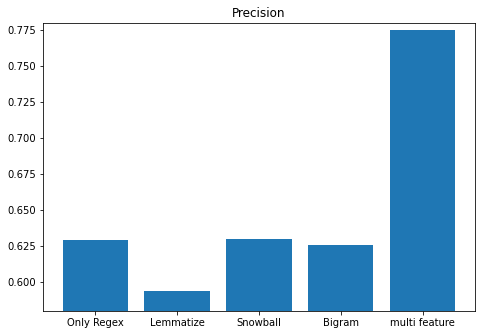

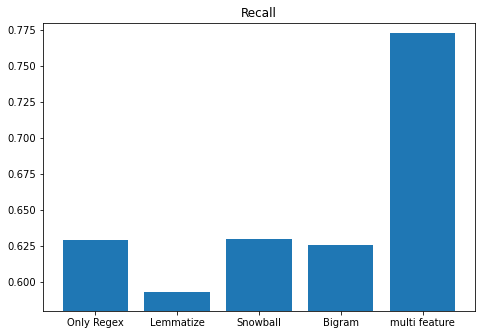

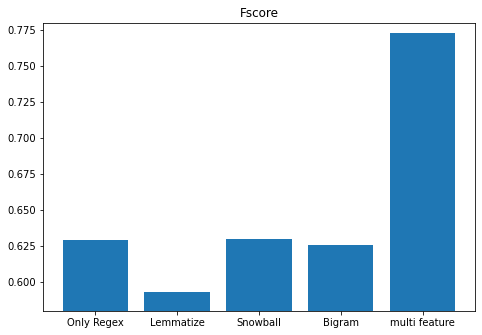

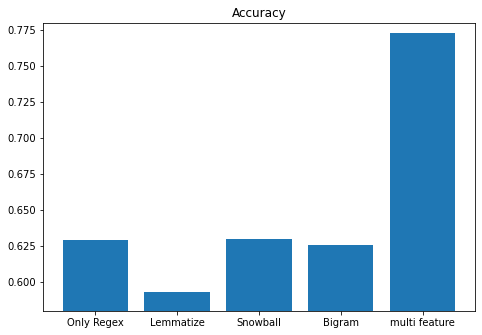



--------------------------------------!!! 😞 WE ARE KICKED OUT DURING PREPROCESSING 😞 !!!------------------------------------

 {' ': 1, ',': 2, '.': 3, "'": 4, '<': 5, '/': 6, '>': 7, '?': 8, '!': 9, '[': 10, ':': 11, '-': 12, ']': 13, '(': 14, ')': 15, '$': 16, '&': 17, ';': 18, '#': 19, '"': 20, '’': 21, '%': 22, '*': 23, '~': 24, '=': 25, '+': 26, '–': 27, '@': 28, '—': 29, '{': 30, '}': 31, '😖': 32, '”': 33, '“': 34, '\u200f': 35, '\\': 36, '`': 37, '…': 38, '，': 39, '®': 40, '‘': 41, '\u200b': 42, '|': 43, '☆': 44, '™': 45, '：': 46, '😀': 47, '。': 48, '^': 49, '😊': 50, '👏': 51, '´': 52, '！': 53, '¬': 54, '★': 55, '\xa0': 56, '🎥': 57, '✅': 58, '🍅': 59, '◆': 60, '▪': 61, '″': 62, '·': 63, '�': 64, '👌': 65, '¡': 66, '🐈': 67, '💞': 68, '😆': 69, '😍': 70, '👍': 71, '💖': 72, '💗': 73, '°': 74, '†': 75, '😉': 76, '¯': 77, '💜': 78, '×': 79, '😘': 80, '±': 81, '▶': 82, '•': 83, '∙': 84, '\x1a': 85, '¢': 86, '😞': 87}


 and also the 301 Hyperlinks !!! ......along with 563 numbers!!!!!




In [21]:
import matplotlib.pyplot as plt

using = ["Only Regex", "Lemmatize", "Snowball", "Bigram","multi feature"]
Precision = [0.629317866998244,0.5936564293366243,0.6299748454099972,0.6259062570686007,0.7751091703056768]
Recall = [0.6290476190476191,0.5928571428571429,0.6297619047619047,0.6257142857142857,0.7728571428571429]
FScore =[0.6288537140492447,0.591986621796936,0.6296102003229782,0.6255715614046986,0.7723913450996654]
Accuracy = [0.6290476190476191,0.5928571428571429,0.6297619047619047,0.6257142857142857,0.7728571428571429]

fig1 = plt.figure()
pc = fig1.add_axes([1,1,1,1])
pc.set_ylim(0.58, 0.78)
pc.set_title("Precision")
pc.bar(using,Precision)

fig2 = plt.figure()
rc = fig2.add_axes([1,1,1,1])
rc.set_ylim(0.58, 0.78)
rc.set_title("Recall")
rc.bar(using,Recall)

fig3 = plt.figure()
fs = fig3.add_axes([1,1,1,1])
fs.set_ylim(0.58, 0.78)
fs.set_title("Fscore")
fs.bar(using,Recall)

fig4 = plt.figure()
ac = fig4.add_axes([1,1,1,1])
ac.set_ylim(0.58, 0.78)
ac.set_title("Accuracy")
ac.bar(using,Recall)

plt.show()

        #Precision #Recall #F Score #Accuracy
#REGEX
#LEMMATIZE
#STEMMING
#BIGRAM
#Adding beyond Textual Features......

print('\n')
print("--------------------------------------!!! 😞 WE ARE KICKED OUT DURING PREPROCESSING 😞 !!!------------------------------------")
print('\n', spl_char)
print('\n')
print(" and also the" , len(hpr_link), "Hyperlinks !!!", "......along with", len(numbers), "numbers!!!!!")
print('\n')

# Observations

1.  Its observed in exploratory way and via regex that the reviews were having hyper links, html tags which doesnt provide and valuable information to identify the classes. 
3.  Lemmmatize, though reduced the tokens to a certain extent fromm the previous tokenized list, together with bigram it gave a significant increase in the feature counts.
3.  The scores gradually increased while applying stemming after lemmatizing. 
4.  The high level of peformance was observed when additional features were taken into consideration. 
5.  Finally the precision, recall, f-score and accuracy have a reached nearly 77% percentage from the lowest percentage (of around 59% while lemmatizing)